**Imports**

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, BaggingRegressor
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score
)
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

**Combined dataset**

In [13]:
file_path = "./combined_dataset_with_groups_and_time.xlsx"
grade_interval = 15

data_first_to_six = pd.read_excel(file_path)

XSix = data_first_to_six.drop(columns=['Improg_Final_Exam', 'Prog_Final_Exam', 'AnonymId', 'Improg_Bonus_Weekly_Exam_Retake', 'Improg_Seventh_Weekly_Exam','Improg_Eighth_Weekly_Exam','Improg_Ninth_Weekly_Exam', 'Improg_Tenth_Weekly_Exam',
                                       'Prog_Seventh_Weekly_Exam','Prog_Eighth_Weekly_Exam','Prog_Ninth_Weekly_Exam', 'Prog_Tenth_Weekly_Exam'])
YSix = data_first_to_six[['Prog_Final_Exam', 'Improg_Final_Exam']]
print(XSix)
print(YSix)

XSix_train, XSix_test, YSix_train, YSix_test = train_test_split(XSix, YSix, test_size=0.2, random_state=42)

     Prog_Group  Prog_First_Weekly_Exam  Prog_Second_Weekly_Exam  \
0             1                     2.0                      2.0   
1            13                     1.0                      2.0   
2            20                     2.0                      1.8   
3             7                     2.0                      2.0   
4             1                     2.0                      2.0   
..          ...                     ...                      ...   
303          11                     2.0                      1.0   
304           4                     2.0                      2.0   
305          10                     2.0                      2.0   
306          13                     2.0                      2.0   
307           7                     2.0                      2.0   

     Prog_Third_Weekly_Exam  Prog_Fourth_Weekly_Exam  Prog_Fifth_Weekly_Exam  \
0                       2.0                      1.0                     2.0   
1                      

**Subject-Based Classifier**

In [4]:
def classify_grade_base(score, max_score=50, interval=15):
    excellent_threshold = max_score * 0.85  # 42.5
    good_threshold = max_score * 0.7        # 35
    medium_threshold = max_score * 0.55     # 27.5
    sufficient_threshold = max_score * 0.4  # 20

    if score > excellent_threshold:
        return "EXCELLENT"
    elif good_threshold < score <= excellent_threshold:
        return "GOOD"
    elif medium_threshold < score <= good_threshold:
        return "AVERAGE"
    elif sufficient_threshold < score <= medium_threshold:
        return "SATISFACTORY"
    else:
        return "FAIL"

#test_scores = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
#results = {score: classify_grade_base(score) for score in test_scores}
#print(results)

**Performance-Tiered Classifier**

In [5]:
def classify_grade_performance(score, max_score=50):
    high_threshold = max_score * 0.6  # Top 60% and above
    medium_threshold = max_score * 0.4  # Middle 30-60%

    if score >= high_threshold:
        return "HIGH"
    elif score >= medium_threshold:
        return "AVERAGE"
    else:
        return "LOW"

#test_scores = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
#results = {score: classify_grade(score) for score in test_scores}
#print(results)

**Buffer-Zone Classifier**

In [6]:
def classify_grade_buffer(score, max_score=50, interval=15, buffer=0.06):
    # Define grade thresholds
    excellent_threshold = max_score * 0.85
    good_threshold = max_score * 0.7
    medium_threshold = max_score * 0.55
    sufficient_threshold = max_score * 0.4

    buffer_zone = max_score * buffer

    # Apply grading logic with buffer zones
    if score > excellent_threshold or (excellent_threshold - buffer_zone) <= score:
        return "EXCELLENT"
    elif good_threshold < score <= excellent_threshold or (good_threshold - buffer_zone) <= score < excellent_threshold:
        return "GOOD"
    elif medium_threshold < score <= good_threshold or (medium_threshold - buffer_zone) <= score < good_threshold:
        return "AVERAGE"
    elif sufficient_threshold < score <= medium_threshold or (sufficient_threshold - buffer_zone) <= score < medium_threshold:
        return "SATISFACTORY"
    else:
        return "FAIL"

#test_scores = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
#results = {score: classify_grade(score) for score in test_scores}
#print(results)

**Metrics calculation**

In [24]:
def calculate_metrics(y_test, y_pred, classify_test=classify_grade_base, classify_actual=classify_grade_base):
    test_grades = y_test.apply(lambda x: classify_test(x))
    actual_grades = pd.Series(y_pred).apply(lambda x: classify_actual(x))

    metrics = {
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "Accuracy": accuracy_score(test_grades, actual_grades)
    }
    return metrics

**Best Random Forest Variant: Bagged Random Forest trained on Combined Dataset**

In [14]:
multi_rf = MultiOutputRegressor(BaggingRegressor(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    n_estimators=10,
    random_state=42
))

multi_rf.fit(XSix_train, YSix_train)
YSix_pred_bagged_rf = multi_rf.predict(XSix_test)

In [29]:
regression_metrics = []
accuracy_metrics = []

for i, col in enumerate(YSix_test.columns):
    reg = calculate_metrics(YSix_test[col], YSix_pred_bagged_rf[:, i])
    regression_metrics.append({
        "Subject": col,
        "MSE": reg["MSE"],
        "RMSE": reg["RMSE"],
        "MAE": reg["MAE"],
        "R2": reg["R2"]
    })

for i, col in enumerate(YSix_test.columns):
    acc = calculate_metrics(YSix_test[col], YSix_pred_bagged_rf[:, i])
    accuracy_metrics.append({
        "Subject": col,
        "Grading Scheme": "Subject-Based",
        "Accuracy": round(acc["Accuracy"] * 100, 2)
    })

for i, col in enumerate(YSix_test.columns):
    acc = calculate_metrics(YSix_test[col], YSix_pred_bagged_rf[:, i],
                             classify_grade_buffer, classify_grade_base)
    accuracy_metrics.append({
        "Subject": col,
        "Grading Scheme": "Buffer-Zone",
        "Accuracy": round(acc["Accuracy"] * 100, 2)
    })

for i, col in enumerate(YSix_test.columns):
    acc = calculate_metrics(YSix_test[col], YSix_pred_bagged_rf[:, i],
                             classify_grade_performance, classify_grade_performance)
    accuracy_metrics.append({
        "Subject": col,
        "Grading Scheme": "Performance-Tiered",
        "Accuracy": round(acc["Accuracy"] * 100, 2)
    })

bagged_regression_df = pd.DataFrame(regression_metrics)
bagged_accuracy_df = pd.DataFrame(accuracy_metrics)

display(bagged_regression_df)
display(bagged_accuracy_df)

,Subject,MSE,RMSE,MAE,R2
0,Prog_Final_Exam,29.234358,5.406881,3.715298,0.502010
1,Improg_Final_Exam,65.707700,8.106029,6.628347,0.358017


,Subject,Grading Scheme,Accuracy
0,Prog_Final_Exam,Subject-Based,83.87
1,Improg_Final_Exam,Subject-Based,32.26
2,Prog_Final_Exam,Buffer-Zone,85.48
3,Improg_Final_Exam,Buffer-Zone,40.32
4,Prog_Final_Exam,Performance-Tiered,96.77
5,Improg_Final_Exam,Performance-Tiered,83.87


**Best SVM Variant: Stacked SVM trained on Combined Dataset**

In [19]:
base_models_six = [
    ('svm', SVR()),
    ('rfr', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, random_state=42))
]

stack = StackingRegressor(
    estimators=base_models_six,
    final_estimator=Ridge(alpha=1.0),
    passthrough=True)

multioutput_stack = MultiOutputRegressor(stack)
multioutput_stack.fit(XSix_train, YSix_train)
y_pred_stacked_six = multioutput_stack.predict(XSix_test)

In [26]:
stacked_regression_metrics = []
stacked_accuracy_metrics = []

for i, col in enumerate(YSix_test.columns):
    reg = calculate_metrics(YSix_test[col], y_pred_stacked_six[:, i])
    stacked_regression_metrics.append({
        "Subject": col,
        "MSE": reg["MSE"],
        "RMSE": reg["RMSE"],
        "MAE": reg["MAE"],
        "R2": reg["R2"]
    })

for i, col in enumerate(YSix_test.columns):
    acc = calculate_metrics(YSix_test[col], y_pred_stacked_six[:, i])
    stacked_accuracy_metrics.append({
        "Subject": col,
        "Grading Scheme": "Subject-Based",
        "Accuracy": round(acc["Accuracy"] * 100, 2)
    })

for i, col in enumerate(YSix_test.columns):
    acc = calculate_metrics(YSix_test[col], y_pred_stacked_six[:, i],
                            classify_grade_buffer, classify_grade_base)
    stacked_accuracy_metrics.append({
        "Subject": col,
        "Grading Scheme": "Buffer-Zone",
        "Accuracy": round(acc["Accuracy"] * 100, 2)
    })

for i, col in enumerate(YSix_test.columns):
    acc = calculate_metrics(YSix_test[col], y_pred_stacked_six[:, i],
                            classify_grade_performance, classify_grade_performance)
    stacked_accuracy_metrics.append({
        "Subject": col,
        "Grading Scheme": "Performance-Tiered",
        "Accuracy": round(acc["Accuracy"] * 100, 2)
    })

stacked_regression_df = pd.DataFrame(stacked_regression_metrics)
stacked_accuracy_df = pd.DataFrame(stacked_accuracy_metrics)

display(stacked_regression_df)
display(stacked_accuracy_df)

,Subject,MSE,RMSE,MAE,R2
0,Prog_Final_Exam,28.808284,5.367335,3.673375,0.509268
1,Improg_Final_Exam,75.547262,8.691793,7.147650,0.261882


,Subject,Grading Scheme,Accuracy
0,Prog_Final_Exam,Subject-Based,79.03
1,Improg_Final_Exam,Subject-Based,33.87
2,Prog_Final_Exam,Buffer-Zone,80.65
3,Improg_Final_Exam,Buffer-Zone,38.71
4,Prog_Final_Exam,Performance-Tiered,96.77
5,Improg_Final_Exam,Performance-Tiered,80.65


**Best DNN Variant: Optimized FastAI trained on Combined Dataset**

In [21]:
from fastai.tabular.all import *
!pip install optuna
import optuna
from sklearn.preprocessing import StandardScaler

XSix_train_val, XSix_test, YSix_train_val, YSix_test = train_test_split(XSix, YSix, test_size=0.2, random_state=42)
XSix_train, XSix_val, YSix_train, YSix_val = train_test_split(XSix_train_val, YSix_train_val, test_size=0.25, random_state=42)

scaler_six = StandardScaler()
XSix_train_scaled = scaler_six.fit_transform(XSix_train)
XSix_val_scaled = scaler_six.transform(XSix_val)
XSix_test_scaled = scaler_six.transform(XSix_test)

data_six = pd.concat([XSix_train, XSix_val])
targets_six = pd.concat([YSix_train, YSix_val])
data_six["Prog_Final_Exam"] = targets_six["Prog_Final_Exam"].values
data_six["Improg_Final_Exam"] = targets_six["Improg_Final_Exam"].values
valid_idx_six = list(range(len(XSix_train), len(data_six)))


dls_six = TabularDataLoaders.from_df(
    data_six,
    y_names=["Prog_Final_Exam", "Improg_Final_Exam"],
    cont_names=list(XSix.columns),
    valid_idx=valid_idx_six,
    procs=[Normalize]
)

def objective_six(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
    layer1 = trial.suggest_int('layer1', 100, 250)
    layer2 = trial.suggest_int('layer2', 50, 150)
    wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)

    learn = tabular_learner(
        dls_six,
        metrics=[rmse],
        layers=[layer1, layer2],
        n_out=2,
        wd=wd
    )

    learn.fit_one_cycle(10, learning_rate)
    rmse_value = float(learn.validate()[1])

    return rmse_value

study_six = optuna.create_study(direction='minimize')
study_six.optimize(objective_six, n_trials=20)

best_params_six = study_six.best_params

print("Best Parameters for 6-Exam Model:", best_params_six)

learn_six = tabular_learner(
    dls_six,
    metrics=[rmse],
    layers=[best_params_six['layer1'], best_params_six['layer2']],
    n_out=2,
    wd=best_params_six['wd']
)

learn_six.fit_one_cycle(20, best_params_six['learning_rate'])

test_preds_six_optimized, _ = learn_six.get_preds(dl=dls_six.test_dl(XSix_test))
test_preds_six_optimized = test_preds_six_optimized.numpy()
actual_test_six_optimized = YSix_test.values

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.7 MB/s eta 0:00:00


[I 2025-04-09 10:34:55,261] A new study created in memory with name: no-name-17a8edc0-d2be-4c74-aa22-24c4e9192505
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1935.746338,1842.155151,42.920334,00:00
1,1903.962891,1842.471313,42.924019,00:00
2,1906.281982,1835.594849,42.843842,00:00
3,1893.319336,1819.354614,42.653893,00:00
4,1900.513184,1812.413086,42.572445,00:00
5,1863.524292,1774.448364,42.124203,00:00
6,1848.605957,1739.421387,41.706371,00:00
7,1832.242676,1724.734497,41.529922,00:00
8,1810.518311,1713.245239,41.391365,00:00
9,1794.654297,1700.089233,41.232140,00:00


[I 2025-04-09 10:34:55,799] Trial 0 finished with value: 41.232139587402344 and parameters: {'learning_rate': 0.013406971061461758, 'layer1': 108, 'layer2': 98, 'wd': 0.0001}. Best is trial 0 with value: 41.232139587402344.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1929.785400,1854.514526,43.064075,00:00
1,1935.357300,1849.878296,43.010212,00:00
2,1898.823120,1838.145386,42.873596,00:00
3,1892.510132,1820.077881,42.662373,00:00
4,1887.788818,1793.907715,42.354549,00:00
5,1874.724609,1771.558838,42.089890,00:00
6,1864.282837,1761.293335,41.967766,00:00
7,1845.976440,1755.364868,41.897076,00:00
8,1848.786133,1768.116699,42.048981,00:00
9,1844.247314,1765.216431,42.014481,00:00


[I 2025-04-09 10:34:56,185] Trial 1 finished with value: 42.01448059082031 and parameters: {'learning_rate': 0.009811062483815264, 'layer1': 168, 'layer2': 81, 'wd': 0.0001}. Best is trial 0 with value: 41.232139587402344.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1913.121582,1848.490356,42.994072,00:00
1,1936.981201,1850.385620,43.016109,00:00
2,1913.420654,1849.088013,43.001022,00:00
3,1898.149414,1844.679688,42.949734,00:00
4,1890.505615,1840.416626,42.900078,00:00
5,1892.435303,1838.299438,42.875393,00:00
6,1876.032227,1821.266724,42.676300,00:00
7,1870.796265,1818.008789,42.638115,00:00
8,1856.392822,1803.780029,42.470932,00:00
9,1851.125000,1806.610474,42.504242,00:00


[I 2025-04-09 10:34:56,556] Trial 2 finished with value: 42.504241943359375 and parameters: {'learning_rate': 0.008970783377005931, 'layer1': 118, 'layer2': 71, 'wd': 0.0001}. Best is trial 0 with value: 41.232139587402344.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1908.853149,1850.859253,43.021614,00:00
1,1887.373901,1848.388794,42.992893,00:00
2,1880.323608,1837.835083,42.869980,00:00
3,1882.332275,1818.938965,42.649021,00:00
4,1905.030762,1804.817871,42.483147,00:00
5,1893.474487,1784.252075,42.240410,00:00
6,1868.074829,1761.437988,41.969490,00:00
7,1844.696167,1743.700806,41.757645,00:00
8,1835.739258,1743.426270,41.754356,00:00
9,1823.472778,1746.843506,41.795258,00:00


[I 2025-04-09 10:34:56,960] Trial 3 finished with value: 41.795257568359375 and parameters: {'learning_rate': 0.010260986695304316, 'layer1': 106, 'layer2': 142, 'wd': 0.0001}. Best is trial 0 with value: 41.232139587402344.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1878.918213,1848.977051,42.999733,00:00
1,1866.669067,1845.992432,42.965015,00:00
2,1864.391968,1842.664551,42.926270,00:00
3,1877.106445,1841.186768,42.909054,00:00
4,1874.471191,1835.985107,42.848396,00:00
5,1870.898804,1831.776978,42.799263,00:00
6,1874.624268,1830.978027,42.789928,00:00
7,1864.736328,1822.864502,42.695019,00:00
8,1866.737793,1819.543213,42.656105,00:00
9,1855.843018,1812.926636,42.578476,00:00


[I 2025-04-09 10:34:57,355] Trial 4 finished with value: 42.57847595214844 and parameters: {'learning_rate': 0.0033514875190503958, 'layer1': 112, 'layer2': 109, 'wd': 0.0001}. Best is trial 0 with value: 41.232139587402344.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1981.327393,1849.153442,43.001785,00:00
1,1944.512207,1848.931274,42.999203,00:00
2,1924.324585,1847.127319,42.978218,00:00
3,1912.084473,1844.127563,42.943306,00:00
4,1905.259399,1836.599121,42.855560,00:00
5,1878.997681,1823.069702,42.697422,00:00
6,1868.323975,1810.298096,42.547600,00:00
7,1863.807495,1805.079468,42.486225,00:00
8,1857.503784,1808.455200,42.525936,00:00
9,1853.208008,1809.464722,42.537804,00:00


[I 2025-04-09 10:34:57,737] Trial 5 finished with value: 42.537803649902344 and parameters: {'learning_rate': 0.0062896378948927145, 'layer1': 128, 'layer2': 94, 'wd': 0.0001}. Best is trial 0 with value: 41.232139587402344.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1867.712769,1854.725464,43.066525,00:00
1,1855.753784,1856.109131,43.082584,00:00
2,1859.561035,1838.794800,42.881172,00:00
3,1840.783203,1803.190308,42.463989,00:00
4,1819.163574,1709.858887,41.350441,00:00
5,1786.874634,1581.718140,39.770821,00:00
6,1763.074829,1480.000000,38.470768,00:00
7,1740.005859,1433.350708,37.859619,00:00
8,1714.744629,1417.793579,37.653599,00:00
9,1685.704102,1409.323486,37.540958,00:00


[I 2025-04-09 10:34:58,128] Trial 6 finished with value: 37.540958404541016 and parameters: {'learning_rate': 0.024024882615278232, 'layer1': 213, 'layer2': 84, 'wd': 0.0001}. Best is trial 6 with value: 37.540958404541016.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1872.141357,1850.086548,43.012634,00:00
1,1885.488647,1874.543945,43.296005,00:00
2,1858.077393,1784.616699,42.244724,00:00
3,1845.666504,1704.428467,41.284725,00:00
4,1758.815796,1432.462036,37.847881,00:00
5,1659.186646,1096.798584,33.117950,00:00
6,1550.148071,857.483276,29.282816,00:00
7,1432.530396,729.758606,27.014044,00:00
8,1327.584839,650.594788,25.506760,00:00
9,1242.587158,661.263916,25.715052,00:00


[I 2025-04-09 10:34:58,547] Trial 7 finished with value: 25.715051651000977 and parameters: {'learning_rate': 0.04223135806283132, 'layer1': 182, 'layer2': 142, 'wd': 0.0001}. Best is trial 7 with value: 25.715051651000977.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1887.720093,1834.423584,42.830170,00:00
1,1874.210815,1803.941040,42.472828,00:00
2,1868.373291,1631.700195,40.394310,00:00
3,1837.102173,1477.678955,38.440590,00:00
4,1790.612915,1167.734863,34.172134,00:00
5,1722.085205,1026.927368,32.045708,00:00
6,1644.407471,910.092957,30.167747,00:00
7,1546.754395,800.000916,28.284286,00:00
8,1472.042847,791.239136,28.128973,00:00
9,1396.089844,777.755249,27.888264,00:00


[I 2025-04-09 10:34:58,979] Trial 8 finished with value: 27.888263702392578 and parameters: {'learning_rate': 0.043017971723657025, 'layer1': 173, 'layer2': 90, 'wd': 0.0001}. Best is trial 7 with value: 25.715051651000977.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1919.983398,1847.039429,42.977196,00:00
1,1892.890747,1844.960815,42.953007,00:00
2,1863.937988,1842.459961,42.923885,00:00
3,1834.942993,1838.776978,42.880962,00:00
4,1830.311890,1834.012817,42.825375,00:00
5,1847.192505,1831.217285,42.792725,00:00
6,1863.075562,1831.673218,42.798050,00:00
7,1871.708862,1832.560059,42.808411,00:00
8,1876.244751,1830.380615,42.782948,00:00
9,1878.853882,1832.739990,42.810513,00:00


[I 2025-04-09 10:34:59,373] Trial 9 finished with value: 42.81051254272461 and parameters: {'learning_rate': 0.004335562067041264, 'layer1': 131, 'layer2': 52, 'wd': 0.0001}. Best is trial 7 with value: 25.715051651000977.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1946.400391,1851.093750,43.024338,00:00
1,1931.796387,1851.507812,43.029152,00:00
2,1925.240234,1851.072998,43.024097,00:00
3,1945.722290,1851.265015,43.026329,00:00
4,1928.319458,1850.415161,43.016453,00:00
5,1921.407715,1848.675293,42.996223,00:00
6,1924.016113,1849.738159,43.008583,00:00
7,1911.268921,1848.068481,42.989166,00:00
8,1911.213745,1848.913940,42.999001,00:00
9,1910.041992,1846.826294,42.974716,00:00


[I 2025-04-09 10:34:59,810] Trial 10 finished with value: 42.97471618652344 and parameters: {'learning_rate': 0.001447902783118332, 'layer1': 228, 'layer2': 148, 'wd': 0.0001}. Best is trial 7 with value: 25.715051651000977.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1900.451538,1846.824341,42.974693,00:00
1,1890.920898,1818.728271,42.646549,00:00
2,1865.147095,1737.022095,41.677597,00:00
3,1821.282349,1519.695557,38.983273,00:00
4,1752.125977,1099.283691,33.155449,00:00
5,1635.588623,880.500610,29.673231,00:00
6,1511.152710,682.984192,26.133966,00:00
7,1374.727783,537.029663,23.173901,00:00
8,1253.712280,458.561584,21.414051,00:00
9,1154.013184,446.133209,21.121866,00:00


[I 2025-04-09 10:35:00,223] Trial 11 finished with value: 21.12186622619629 and parameters: {'learning_rate': 0.047625910001046136, 'layer1': 183, 'layer2': 123, 'wd': 0.0001}. Best is trial 11 with value: 21.12186622619629.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1914.759399,1847.961792,42.987926,00:00
1,1874.034912,1832.369263,42.806183,00:00
2,1856.628906,1695.486816,41.176289,00:00
3,1836.826538,1418.503174,37.663021,00:00
4,1741.635864,1054.113770,32.467117,00:00
5,1607.932251,780.065063,27.929646,00:00
6,1474.186157,489.896240,22.133600,00:00
7,1334.493896,339.567535,18.427359,00:00
8,1206.508911,290.756165,17.051573,00:00
9,1101.330078,290.568359,17.046066,00:00


[I 2025-04-09 10:35:00,726] Trial 12 finished with value: 17.046066284179688 and parameters: {'learning_rate': 0.04878816988528715, 'layer1': 199, 'layer2': 126, 'wd': 0.0001}. Best is trial 12 with value: 17.046066284179688.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1938.463501,1851.700073,43.031384,00:00
1,1855.772095,1853.028931,43.046822,00:00
2,1853.744873,1854.382935,43.062546,00:00
3,1848.262207,1825.930420,42.730907,00:00
4,1817.766113,1700.980225,41.242943,00:00
5,1793.301147,1585.417725,39.817303,00:00
6,1756.598511,1502.007324,38.755741,00:00
7,1723.452515,1464.609741,38.270222,00:00
8,1692.592651,1445.424194,38.018734,00:00
9,1663.054810,1439.200806,37.936802,00:00


[I 2025-04-09 10:35:01,262] Trial 13 finished with value: 37.93680191040039 and parameters: {'learning_rate': 0.02246667479319992, 'layer1': 202, 'layer2': 120, 'wd': 0.0001}. Best is trial 12 with value: 17.046066284179688.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1903.948730,1859.709595,43.124352,00:00
1,1872.949097,1860.249268,43.130608,00:00
2,1841.288818,1831.843262,42.800037,00:00
3,1840.395508,1728.489624,41.575108,00:00
4,1824.608887,1638.560913,40.479141,00:00
5,1796.190308,1533.333862,39.157806,00:00
6,1760.826538,1407.788086,37.520504,00:00
7,1701.903198,1316.329712,36.281258,00:00
8,1645.776855,1271.440430,35.657265,00:00
9,1597.755371,1257.617310,35.462902,00:00


[I 2025-04-09 10:35:01,748] Trial 14 finished with value: 35.4629020690918 and parameters: {'learning_rate': 0.026355841193031884, 'layer1': 249, 'layer2': 125, 'wd': 0.0001}. Best is trial 12 with value: 17.046066284179688.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1910.709839,1841.331421,42.910736,00:00
1,1900.611816,1810.858643,42.554184,00:00
2,1856.234253,1656.799927,40.703808,00:00
3,1829.169922,1412.914429,37.588753,00:00
4,1744.023071,1187.226074,34.456146,00:00
5,1619.430054,916.173401,30.268356,00:00
6,1491.475952,623.049133,24.960953,00:00
7,1355.118530,447.716431,21.159311,00:00
8,1231.478027,368.579132,19.198416,00:00
9,1128.248169,351.598236,18.750954,00:00


[I 2025-04-09 10:35:02,194] Trial 15 finished with value: 18.750953674316406 and parameters: {'learning_rate': 0.04873209009470065, 'layer1': 158, 'layer2': 128, 'wd': 0.0001}. Best is trial 12 with value: 17.046066284179688.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1764.078857,1849.116333,43.001354,00:00
1,1813.020264,1850.143799,43.013298,00:00
2,1829.887085,1834.427612,42.830219,00:00
3,1845.412842,1780.188232,42.192276,00:00
4,1830.732910,1676.825806,40.949062,00:00
5,1798.227173,1578.050659,39.724686,00:00
6,1762.258301,1497.939697,38.703224,00:00
7,1740.765625,1480.573853,38.478226,00:00
8,1719.307129,1490.215820,38.603313,00:00
9,1705.296875,1513.304321,38.901211,00:00


[I 2025-04-09 10:35:02,647] Trial 16 finished with value: 38.90121078491211 and parameters: {'learning_rate': 0.01978546358936776, 'layer1': 157, 'layer2': 132, 'wd': 0.0001}. Best is trial 12 with value: 17.046066284179688.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1862.811890,1852.711914,43.043140,00:00
1,1898.896118,1852.105957,43.036102,00:00
2,1936.398804,1851.194824,43.025513,00:00
3,1933.427124,1850.356079,43.015766,00:00
4,1925.304565,1848.606323,42.995422,00:00
5,1911.407227,1846.524536,42.971207,00:00
6,1897.953003,1843.518066,42.936211,00:00
7,1902.026245,1843.037598,42.930614,00:00
8,1890.104614,1841.929932,42.917709,00:00
9,1889.811035,1840.367065,42.899498,00:00


[I 2025-04-09 10:35:03,111] Trial 17 finished with value: 42.899497985839844 and parameters: {'learning_rate': 0.0010503082698419758, 'layer1': 147, 'layer2': 110, 'wd': 0.0001}. Best is trial 12 with value: 17.046066284179688.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1917.496094,1845.705811,42.961678,00:00
1,1883.510254,1837.878540,42.870487,00:00
2,1843.664917,1754.780762,41.890102,00:00
3,1824.602905,1585.785156,39.821918,00:00
4,1798.001221,1400.448730,37.422569,00:00
5,1741.356079,1319.934570,36.330902,00:00
6,1689.243286,1228.192871,35.045582,00:00
7,1623.386841,1162.813965,34.100060,00:00
8,1564.314331,1117.899658,33.435005,00:00
9,1515.538818,1117.739136,33.432606,00:00


[I 2025-04-09 10:35:03,542] Trial 18 finished with value: 33.4326057434082 and parameters: {'learning_rate': 0.03198935834512882, 'layer1': 198, 'layer2': 108, 'wd': 0.0001}. Best is trial 12 with value: 17.046066284179688.
<ipython-input-21-203ac78c95c8>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-21-203ac78c95c8>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1867.643188,1851.517456,43.029263,00:00
1,1889.014038,1851.939941,43.034172,00:00
2,1890.870361,1849.408569,43.004749,00:00
3,1861.421021,1823.481689,42.702244,00:00
4,1846.751831,1758.978638,41.940178,00:00
5,1836.260864,1701.207520,41.245697,00:00
6,1819.617676,1639.692017,40.493111,00:00
7,1796.347168,1596.883301,39.961021,00:00
8,1780.166504,1586.483398,39.830685,00:00
9,1756.487671,1570.602295,39.630825,00:00


[I 2025-04-09 10:35:04,091] Trial 19 finished with value: 39.63082504272461 and parameters: {'learning_rate': 0.01587285121994528, 'layer1': 146, 'layer2': 131, 'wd': 0.0001}. Best is trial 12 with value: 17.046066284179688.


Best Parameters for 6-Exam Model: {'learning_rate': 0.04878816988528715, 'layer1': 199, 'layer2': 126, 'wd': 0.0001}


epoch,train_loss,valid_loss,_rmse,time
0,1868.996338,1839.948608,42.894623,00:00
1,1899.310791,1831.586670,42.797039,00:00
2,1904.110229,1794.665039,42.363487,00:00
3,1900.093506,1610.253052,40.127960,00:00
4,1855.954834,1253.750122,35.408333,00:00
5,1774.127441,948.804993,30.802679,00:00
6,1647.751831,621.621216,24.932333,00:00
7,1494.553223,324.465759,18.012934,00:00
8,1321.869019,190.760834,13.811620,00:00
9,1173.346802,277.934357,16.671364,00:00


In [46]:
optimized_regression_metrics = []
optimized_accuracy_metrics = []

for i, col in enumerate(YSix_test.columns):
    y_true = pd.Series(actual_test_six_optimized[:, i])
    y_pred = pd.Series(test_preds_six_optimized[:, i])

    reg = calculate_metrics(y_true, y_pred)
    optimized_regression_metrics.append({
        "Subject": col,
        "MSE": reg["MSE"],
        "RMSE": reg["RMSE"],
        "MAE": reg["MAE"],
        "R2": reg["R2"]
    })

    acc = calculate_metrics(y_true, y_pred)
    optimized_accuracy_metrics.append({
        "Subject": col,
        "Grading Scheme": "Subject-Based",
        "Accuracy": round(acc["Accuracy"] * 100, 2)
    })

    acc = calculate_metrics(y_true, y_pred, classify_grade_buffer, classify_grade_base)
    optimized_accuracy_metrics.append({
        "Subject": col,
        "Grading Scheme": "Buffer-Zone",
        "Accuracy": round(acc["Accuracy"] * 100, 2)
    })

    acc = calculate_metrics(y_true, y_pred, classify_grade_performance, classify_grade_performance)
    optimized_accuracy_metrics.append({
        "Subject": col,
        "Grading Scheme": "Performance-Tiered",
        "Accuracy": round(acc["Accuracy"] * 100, 2)
    })

optimized_regression_df = pd.DataFrame(optimized_regression_metrics)
optimized_accuracy_df = pd.DataFrame(optimized_accuracy_metrics)

display(optimized_regression_df)
display(optimized_accuracy_df)

,Subject,MSE,RMSE,MAE,R2
0,Prog_Final_Exam,35.790937,5.982553,4.629559,0.390323
1,Improg_Final_Exam,77.748570,8.817515,7.168193,0.240375


,Subject,Grading Scheme,Accuracy
0,Prog_Final_Exam,Subject-Based,80.65
1,Prog_Final_Exam,Buffer-Zone,83.87
2,Prog_Final_Exam,Performance-Tiered,96.77
3,Improg_Final_Exam,Subject-Based,43.55
4,Improg_Final_Exam,Buffer-Zone,35.48
5,Improg_Final_Exam,Performance-Tiered,75.81


<ipython-input-35-9df6ddb3621c>:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=metric_data, x="Subject", y="Value", hue="Model", ci=None, palette="Set2", dodge=True)


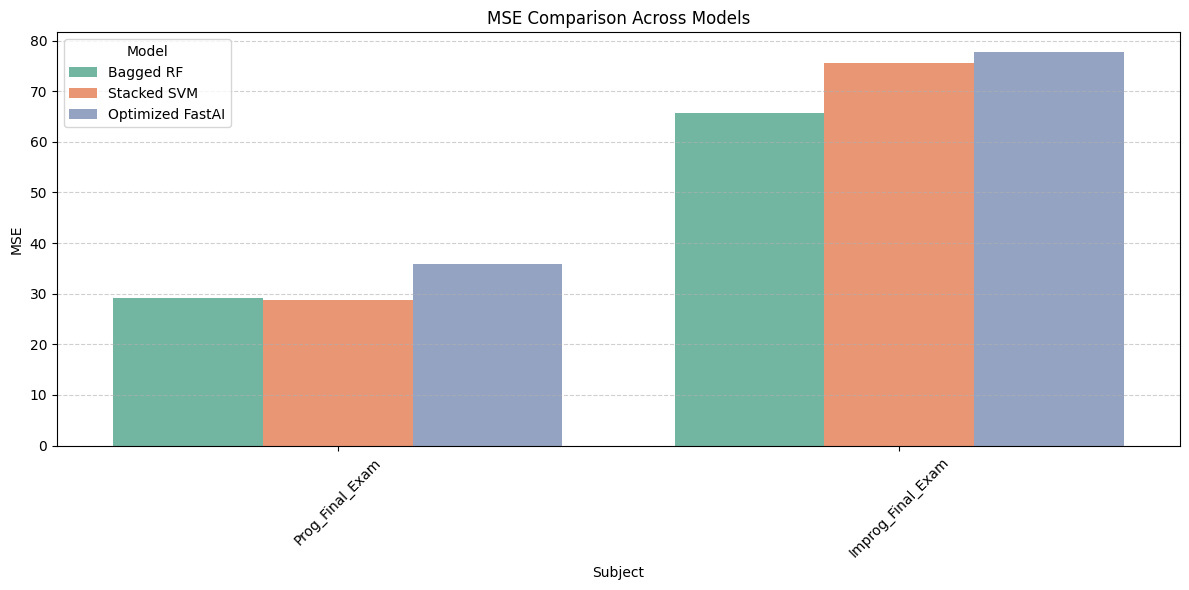

<ipython-input-35-9df6ddb3621c>:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=metric_data, x="Subject", y="Value", hue="Model", ci=None, palette="Set2", dodge=True)


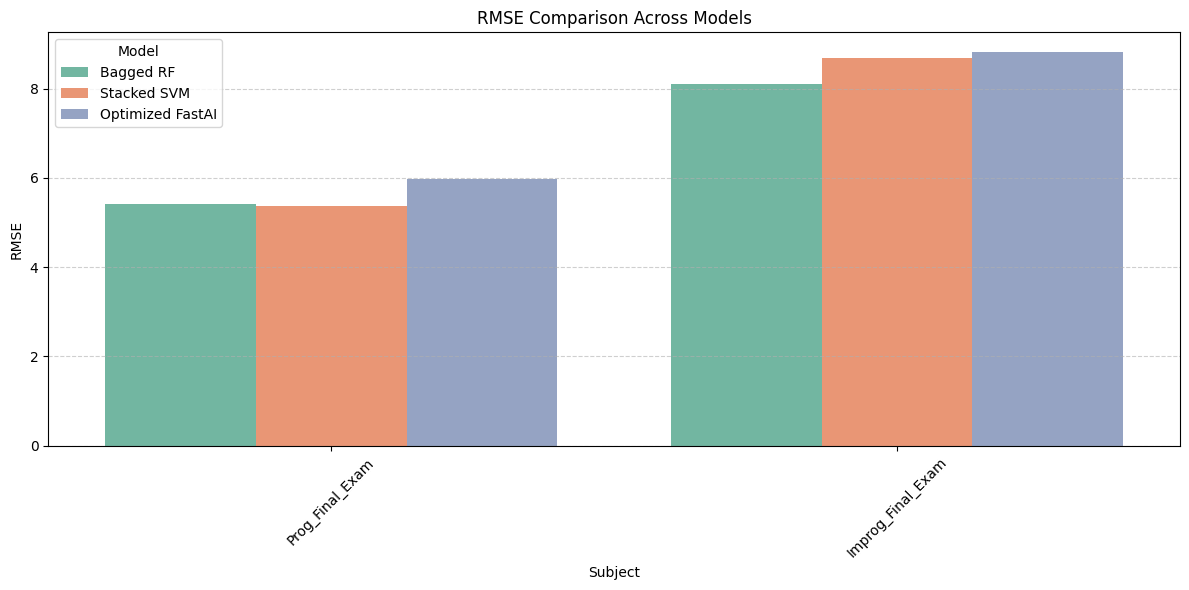

<ipython-input-35-9df6ddb3621c>:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=metric_data, x="Subject", y="Value", hue="Model", ci=None, palette="Set2", dodge=True)


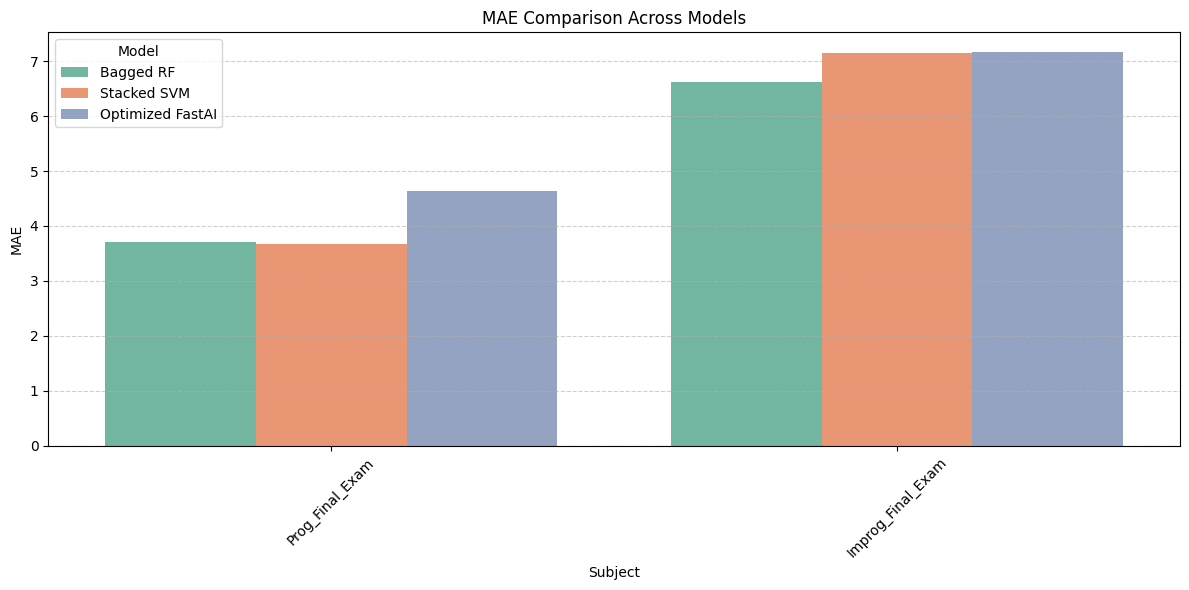

<ipython-input-35-9df6ddb3621c>:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=metric_data, x="Subject", y="Value", hue="Model", ci=None, palette="Set2", dodge=True)


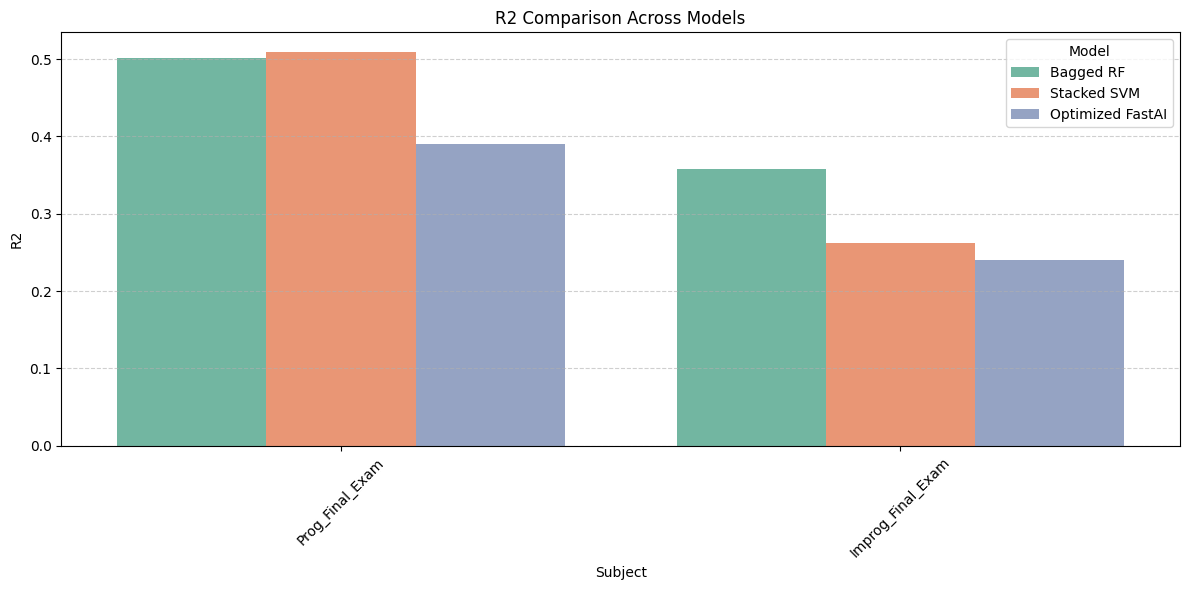

In [35]:
# Add "Model" columns
bagged_regression_df["Model"] = "Bagged RF"
stacked_regression_df["Model"] = "Stacked SVM"
optimized_regression_df["Model"] = "Optimized FastAI"

# Egyesítés
combined_regression = pd.concat([
    bagged_regression_df,
    stacked_regression_df,
    optimized_regression_df
], ignore_index=True)

# Melt az ábrázoláshoz
melted_reg = pd.melt(combined_regression,
                     id_vars=["Subject", "Model"],
                     value_vars=["MSE", "RMSE", "MAE", "R2"],
                     var_name="Metric",
                     value_name="Value")

for metric in ["MSE", "RMSE", "MAE", "R2"]:
    plt.figure(figsize=(12, 6))
    metric_data = melted_reg[melted_reg["Metric"] == metric]
    sns.barplot(data=metric_data, x="Subject", y="Value", hue="Model", ci=None, palette="Set2", dodge=True)
    plt.title(f"{metric} Comparison Across Models")
    plt.xlabel("Subject")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()

<ipython-input-48-dd6557fde403>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=scheme_data, x="Subject", y="Accuracy", hue="Model", ci=None, palette="Set1", dodge=True, ax=ax)
<ipython-input-48-dd6557fde403>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=scheme_data, x="Subject", y="Accuracy", hue="Model", ci=None, palette="Set1", dodge=True, ax=ax)
<ipython-input-48-dd6557fde403>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=scheme_data, x="Subject", y="Accuracy", hue="Model", ci=None, palette="Set1", dodge=True, ax=ax)


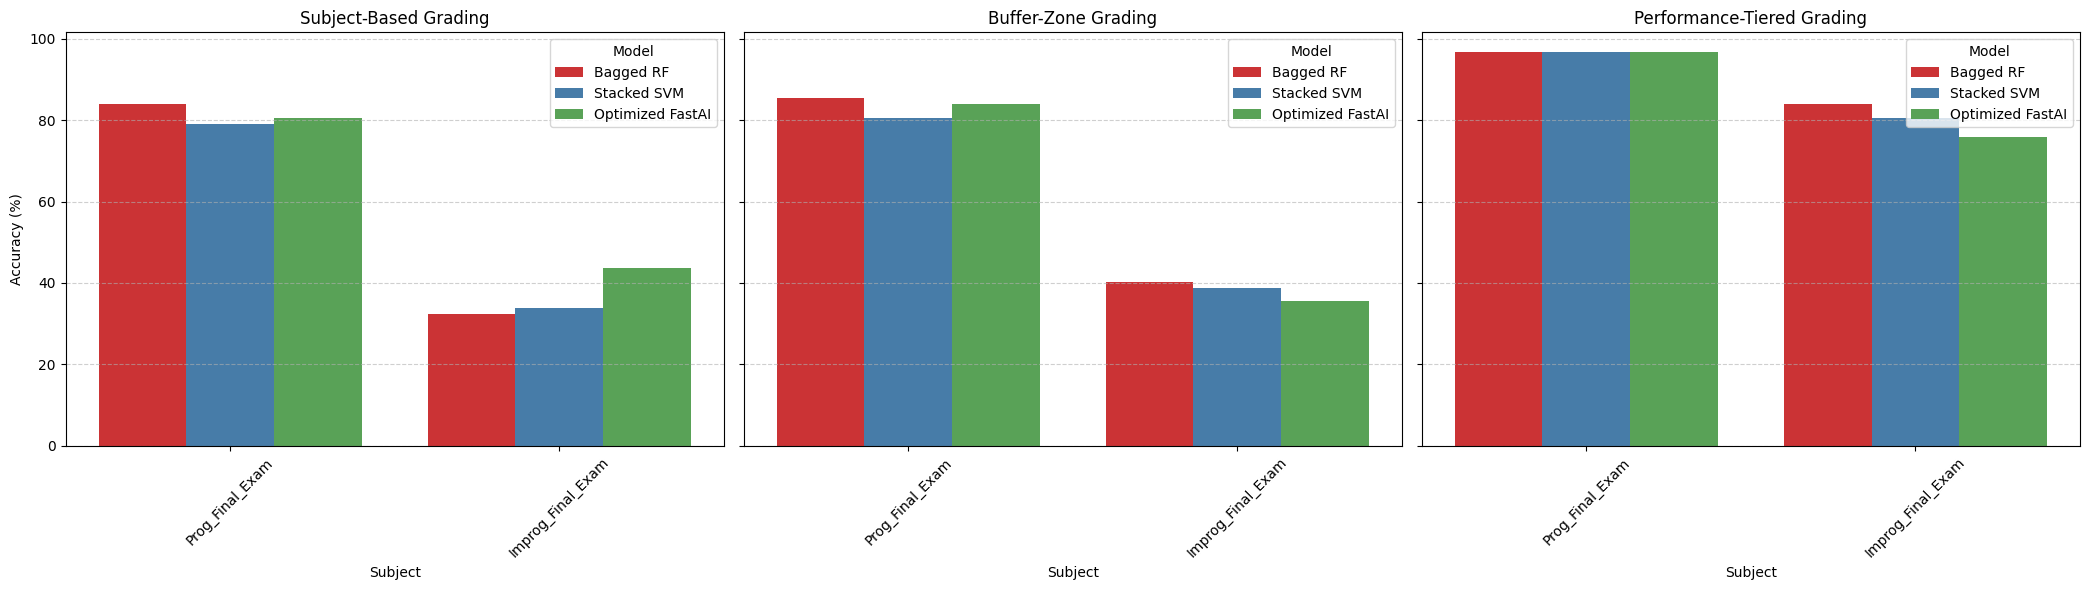

In [48]:
bagged_accuracy_df["Model"] = "Bagged RF"
stacked_accuracy_df["Model"] = "Stacked SVM"
optimized_accuracy_df["Model"] = "Optimized FastAI"

combined_accuracy = pd.concat([
    bagged_accuracy_df,
    stacked_accuracy_df,
    optimized_accuracy_df
], ignore_index=True)

grading_schemes = combined_accuracy["Grading Scheme"].unique()

n = len(grading_schemes)
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(7 * n, 6), sharey=True)

if n == 1:
    axes = [axes]

for ax, scheme in zip(axes, grading_schemes):
    scheme_data = combined_accuracy[combined_accuracy["Grading Scheme"] == scheme]
    sns.barplot(data=scheme_data, x="Subject", y="Accuracy", hue="Model", ci=None, palette="Set1", dodge=True, ax=ax)
    ax.set_title(f"{scheme} Grading")
    ax.set_xlabel("Subject")
    ax.set_ylabel("Accuracy (%)")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax.legend(title="Model")

plt.tight_layout()
plt.show()

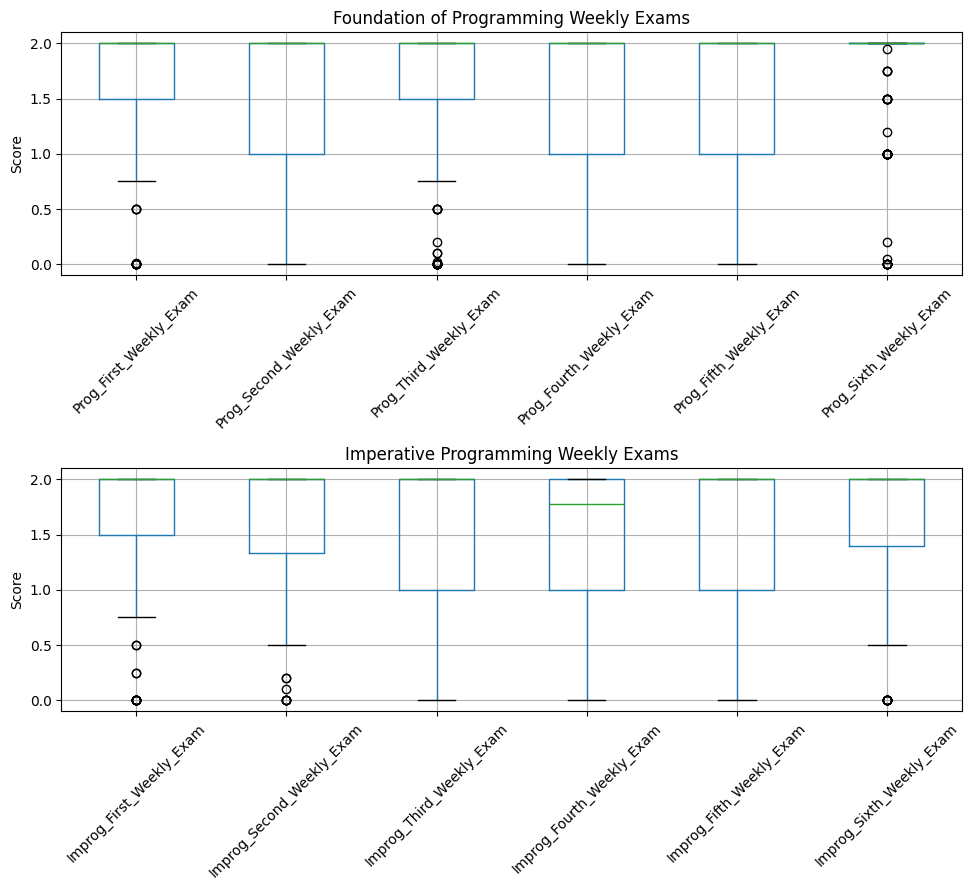

In [37]:
train_df = XSix_train.copy()
train_df["Prog_Final_Exam"] = YSix_train["Prog_Final_Exam"]
train_df["Improg_Final_Exam"] = YSix_train["Improg_Final_Exam"]
exclude_cols = ["_Day", "_Start_Hour", "_Group", "_Assignment"]

prog_cols = [col for col in XSix_train.columns if col.startswith("Prog_") and not any(ex in col for ex in exclude_cols)]
improg_cols = [col for col in XSix_train.columns if col.startswith("Improg_") and not any(ex in col for ex in exclude_cols)]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 9), sharey=True)

train_df[prog_cols].boxplot(ax=axes[0])
axes[0].set_title("Foundation of Programming Weekly Exams")
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylabel("Score")

train_df[improg_cols].boxplot(ax=axes[1])
axes[1].set_title("Imperative Programming Weekly Exams")
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylabel("Score")

plt.tight_layout()
plt.show()

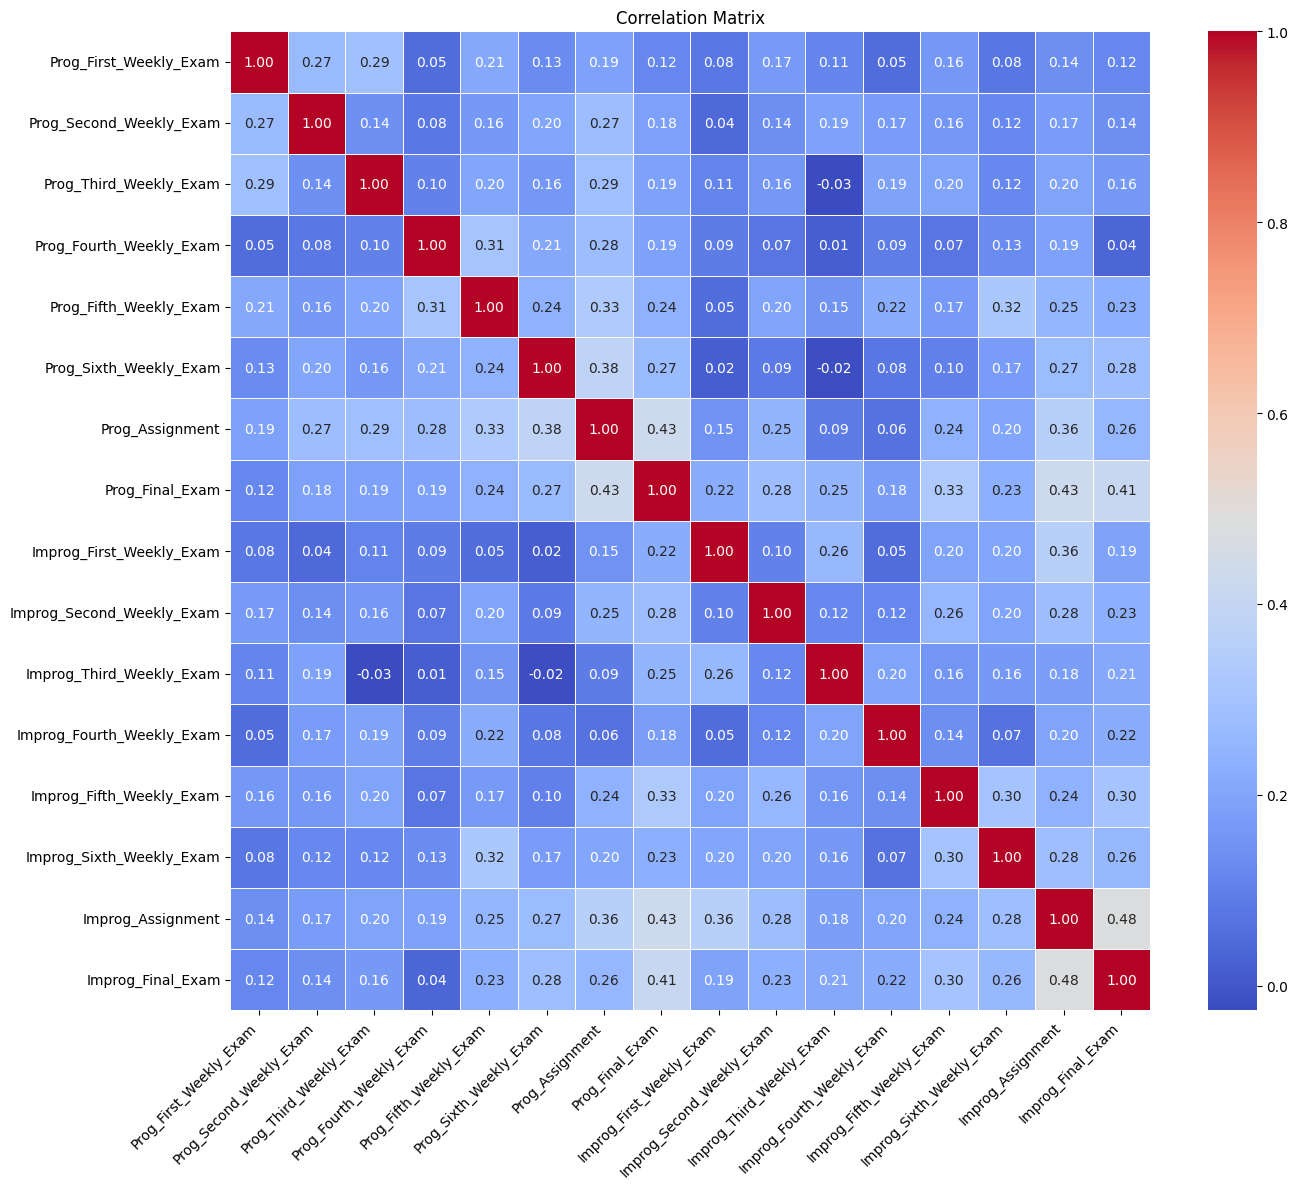

In [45]:
include_keywords = ['Weekly_Exam', 'Assignment', 'Final_Exam']
exclude_keywords = ['Seventh', 'Eighth', 'Ninth', 'Tenth', 'Bonus', 'Day', 'Group', 'Start_Hour']

target_cols = [
    col for col in data_first_to_six.columns
    if any(key in col for key in include_keywords)
    and not any(bad in col for bad in exclude_keywords)
]

corr_df = data_first_to_six[target_cols]
corr_matrix = corr_df.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()